#### Contrastive clustering 

### Trial 1 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


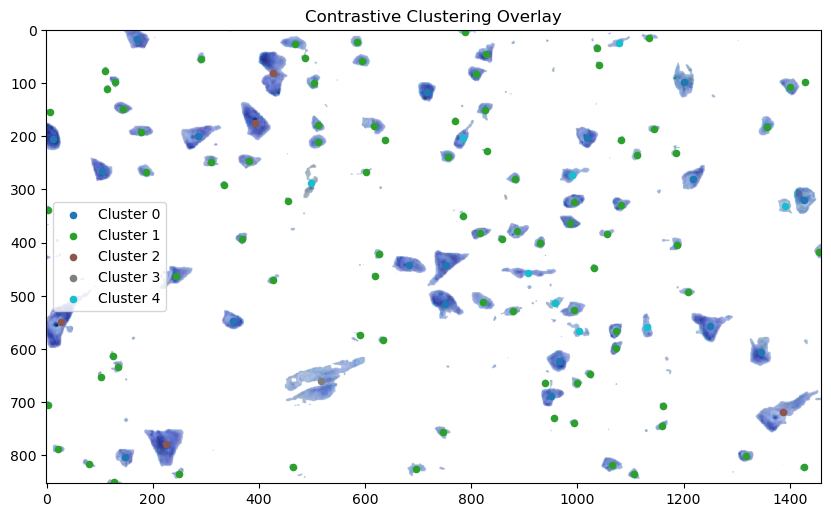

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

import warnings
warnings.filterwarnings("ignore")


# Load clustering dataset (drop Cell Number if present)
clustering_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Update path
df = pd.read_csv(clustering_csv)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values.astype(np.float32)
input_dim = X.shape[1]

# Load centroid dataset
centroid_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"  # Update path
centroid_df = pd.read_csv(centroid_csv)

# Load the image
tissue_image_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\restored_white_background_debug-Copy1.png"  # Update path
tissue_img = cv2.imread(tissue_image_path)
tissue_img = cv2.cvtColor(tissue_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Encoder Model
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation=None)(x)
    return models.Model(inputs, latent, name="encoder")

# Train Encoder
def train_contrastive_encoder(X, latent_dim, epochs=30, batch_size=64):
    encoder = build_encoder(latent_dim)
    optimizer = optimizers.Adam(learning_rate=0.001)
    dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1024).batch(batch_size)
    for epoch in range(epochs):
        for batch in dataset:
            with tf.GradientTape() as tape:
                latent_repr = encoder(batch, training=True)
                loss = tf.reduce_mean(tf.square(latent_repr))  # Dummy loss
            grads = tape.gradient(loss, encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, encoder.trainable_variables))
    return encoder

# Train encoder and cluster
latent_dim = 12
encoder = train_contrastive_encoder(X, latent_dim)
latent_repr = encoder.predict(X)
n_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(latent_repr)

# Map clusters back to centroid CSV
centroid_df["Cluster"] = labels

# Plot overlay
plt.figure(figsize=(10, 10))
plt.imshow(tissue_img)
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_id, color in enumerate(colors):
    subset = centroid_df[centroid_df["Cluster"] == cluster_id]
    plt.scatter(subset["X Centroid"], subset["Y Centroid"], color=color, label=f"Cluster {cluster_id}", s=20)
plt.legend()
plt.title("Contrastive Clustering Overlay")
plt.show()


### set Random seed to 42 

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000016039A83C40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Silhouette Score: 0.602


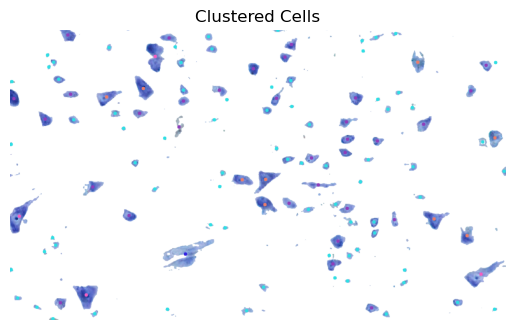

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import ParameterSampler
import random

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load clustering data
clustering_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Replace with your actual path
df = pd.read_csv(clustering_csv)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values.astype(np.float32)
input_dim = X.shape[1]

# Load centroid data
centroid_csv =  r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"   # Replace with your actual path
centroid_df = pd.read_csv(centroid_csv)

# Load original image
image_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\restored_white_background_debug-Copy1.png"  # Replace with your actual path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define contrastive learning model
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation=None)(x)
    model = models.Model(inputs, latent, name="encoder")
    return model

def build_projection_head(latent_dim, projection_dim=32):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    outputs = layers.Dense(projection_dim, activation=None)(x)
    model = models.Model(inputs, outputs, name="projection")
    return model

def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    similarities = tf.matmul(z1, z2, transpose_b=True) / temperature
    labels = tf.range(tf.shape(z1)[0])
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, similarities, from_logits=True)
    return tf.reduce_mean(loss)

def train_contrastive_encoder(X, latent_dim, epochs=30, batch_size=64, temperature=0.5):
    encoder = build_encoder(latent_dim)
    projection = build_projection_head(latent_dim)
    optimizer = optimizers.Adam(learning_rate=0.001)
    dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1024).batch(batch_size)
    
    for epoch in range(epochs):
        for batch in dataset:
            x1 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            x2 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            with tf.GradientTape() as tape:
                z1 = encoder(x1, training=True)
                z2 = encoder(x2, training=True)
                p1 = projection(z1, training=True)
                p2 = projection(z2, training=True)
                loss = nt_xent_loss(p1, p2, temperature=temperature)
            gradients = tape.gradient(loss, encoder.trainable_variables + projection.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projection.trainable_variables))
    return encoder

# Run contrastive clustering
latent_dim = 12  # Adjust as needed
n_clusters = 5   # Adjust as needed
encoder = train_contrastive_encoder(X, latent_dim=latent_dim)
latent_repr = encoder.predict(X)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(latent_repr)

# Compute silhouette score
sil_score = silhouette_score(latent_repr, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Overlay clusters onto image
colors = np.random.randint(0, 255, size=(n_clusters, 3))
for i, row in centroid_df.iterrows():
    x, y = int(row['X Centroid']), int(row['Y Centroid'])
    cluster = labels[i]
    color = tuple(int(c) for c in colors[cluster])
    cv2.circle(image, (x, y), radius=5, color=color, thickness=-1)

# Save and show the image
output_path = "clustered_image.png"
cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.imshow(image)
plt.axis('off')
plt.title("Clustered Cells")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Silhouette Score: 0.569


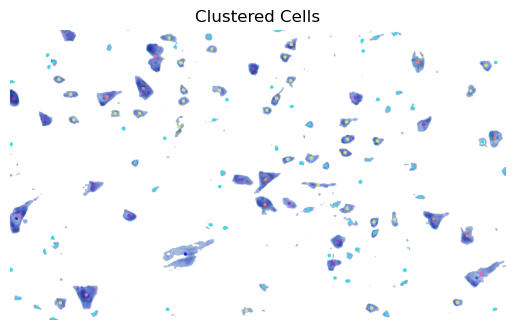

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import ParameterSampler
import random

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load clustering data
clustering_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Replace with your actual path
df = pd.read_csv(clustering_csv)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values.astype(np.float32)
input_dim = X.shape[1]

# Load centroid data
centroid_csv =  r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"   # Replace with your actual path
centroid_df = pd.read_csv(centroid_csv)

# Load original image
image_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\restored_white_background_debug-Copy1.png"  # Replace with your actual path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define contrastive learning model
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation=None)(x)
    model = models.Model(inputs, latent, name="encoder")
    return model

def build_projection_head(latent_dim, projection_dim=32):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    outputs = layers.Dense(projection_dim, activation=None)(x)
    model = models.Model(inputs, outputs, name="projection")
    return model

def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    similarities = tf.matmul(z1, z2, transpose_b=True) / temperature
    labels = tf.range(tf.shape(z1)[0])
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, similarities, from_logits=True)
    return tf.reduce_mean(loss)

def train_contrastive_encoder(X, latent_dim, epochs=30, batch_size=64, temperature=0.5):
    encoder = build_encoder(latent_dim)
    projection = build_projection_head(latent_dim)
    optimizer = optimizers.Adam(learning_rate=0.001)
    dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1024).batch(batch_size)
    
    for epoch in range(epochs):
        for batch in dataset:
            x1 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            x2 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            with tf.GradientTape() as tape:
                z1 = encoder(x1, training=True)
                z2 = encoder(x2, training=True)
                p1 = projection(z1, training=True)
                p2 = projection(z2, training=True)
                loss = nt_xent_loss(p1, p2, temperature=temperature)
            gradients = tape.gradient(loss, encoder.trainable_variables + projection.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projection.trainable_variables))
    return encoder

# Run contrastive clustering
latent_dim = 12  # Adjust as needed
n_clusters = 6   # Adjust as needed
encoder = train_contrastive_encoder(X, latent_dim=latent_dim)
latent_repr = encoder.predict(X)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(latent_repr)

# Compute silhouette score
sil_score = silhouette_score(latent_repr, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Overlay clusters onto image
colors = np.random.randint(0, 255, size=(n_clusters, 3))
for i, row in centroid_df.iterrows():
    x, y = int(row['X Centroid']), int(row['Y Centroid'])
    cluster = labels[i]
    color = tuple(int(c) for c in colors[cluster])
    cv2.circle(image, (x, y), radius=5, color=color, thickness=-1)

# Save and show the image
output_path = "clustered_image.png"
cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.imshow(image)
plt.axis('off')
plt.title("Clustered Cells")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Silhouette Score: 0.602


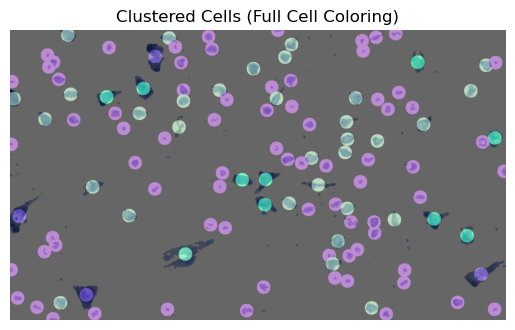

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import ParameterSampler
import random

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load clustering data
clustering_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Replace with your actual path
df = pd.read_csv(clustering_csv)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values.astype(np.float32)
input_dim = X.shape[1]

# Load centroid data
centroid_csv =  r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"   # Replace with your actual path
centroid_df = pd.read_csv(centroid_csv)

# Load original image
image_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\restored_white_background_debug-Copy1.png"  # Replace with your actual path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define contrastive learning model
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation=None)(x)
    model = models.Model(inputs, latent, name="encoder")
    return model

def build_projection_head(latent_dim, projection_dim=32):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    outputs = layers.Dense(projection_dim, activation=None)(x)
    model = models.Model(inputs, outputs, name="projection")
    return model

def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    similarities = tf.matmul(z1, z2, transpose_b=True) / temperature
    labels = tf.range(tf.shape(z1)[0])
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, similarities, from_logits=True)
    return tf.reduce_mean(loss)

def train_contrastive_encoder(X, latent_dim, epochs=30, batch_size=64, temperature=0.5):
    encoder = build_encoder(latent_dim)
    projection = build_projection_head(latent_dim)
    optimizer = optimizers.Adam(learning_rate=0.001)
    dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1024).batch(batch_size)
    
    for epoch in range(epochs):
        for batch in dataset:
            x1 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            x2 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            with tf.GradientTape() as tape:
                z1 = encoder(x1, training=True)
                z2 = encoder(x2, training=True)
                p1 = projection(z1, training=True)
                p2 = projection(z2, training=True)
                loss = nt_xent_loss(p1, p2, temperature=temperature)
            gradients = tape.gradient(loss, encoder.trainable_variables + projection.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projection.trainable_variables))
    return encoder

# Run contrastive clustering
latent_dim = 12  # Adjust as needed
n_clusters = 5   # Adjust as needed
encoder = train_contrastive_encoder(X, latent_dim=latent_dim)
latent_repr = encoder.predict(X)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(latent_repr)

# Compute silhouette score
sil_score = silhouette_score(latent_repr, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Overlay clusters onto image (FULL CELL COLORING)
colors = np.random.randint(0, 255, size=(n_clusters, 3), dtype=np.uint8)
mask = np.zeros_like(image, dtype=np.uint8)

for i, row in centroid_df.iterrows():
    x, y = int(row['X Centroid']), int(row['Y Centroid'])
    cluster = labels[i]
    color = tuple(int(c) for c in colors[cluster])

    # Fill entire cell region based on centroid position
    cv2.circle(mask, (x, y), radius=20, color=color, thickness=-1)  # Adjust radius as needed

# Apply color overlay
alpha = 0.6  # Transparency level
overlayed_image = cv2.addWeighted(image, 1 - alpha, mask, alpha, 0)

# Save and show the image
output_path = "clustered_image.png"
cv2.imwrite(output_path, cv2.cvtColor(overlayed_image, cv2.COLOR_RGB2BGR))
plt.imshow(overlayed_image)
plt.axis('off')
plt.title("Clustered Cells (Full Cell Coloring)")
plt.show()

In [14]:
import numpy as np

# Extract the weights from the first dense layer
first_dense_layer = encoder.layers[1]  # The first Dense(128, relu) layer
weights, biases = first_dense_layer.get_weights()

# Compute feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights), axis=1)

# Normalize feature importance to sum to 1
feature_importance /= np.sum(feature_importance)

# Rank features by importance
feature_ranking = np.argsort(feature_importance)[::-1]

# Display results
print("Feature Importance Ranking:")
for i, idx in enumerate(feature_ranking):
    print(f"Rank {i+1}: Feature {idx} - Importance {feature_importance[idx]:.4f}")


Feature Importance Ranking:
Rank 1: Feature 7 - Importance 0.1203
Rank 2: Feature 3 - Importance 0.1176
Rank 3: Feature 0 - Importance 0.1154
Rank 4: Feature 5 - Importance 0.1114
Rank 5: Feature 8 - Importance 0.1111
Rank 6: Feature 4 - Importance 0.1083
Rank 7: Feature 1 - Importance 0.1061
Rank 8: Feature 6 - Importance 0.1051
Rank 9: Feature 2 - Importance 0.1048


In [16]:
feature_names = df.columns  # Get actual feature names
ranked_features = [(feature_names[idx], feature_importance[idx]) for idx in feature_ranking]

print("Feature Importance Ranking:")
for i, (name, importance) in enumerate(ranked_features):
    print(f"Rank {i+1}: {name} - Importance {importance:.4f}")


Feature Importance Ranking:
Rank 1: Solidity - Importance 0.1203
Rank 2: Minor Axis Length - Importance 0.1176
Rank 3: Area - Importance 0.1154
Rank 4: Aspect Ratio - Importance 0.1114
Rank 5: Local Homogeneity - Importance 0.1111
Rank 6: Soma Diameter - Importance 0.1083
Rank 7: Perimeter - Importance 0.1061
Rank 8: Circularity - Importance 0.1051
Rank 9: Major Axis Length - Importance 0.1048


In [18]:
print(df.columns.tolist())

['Area', 'Perimeter', 'Major Axis Length', 'Minor Axis Length', 'Soma Diameter', 'Aspect Ratio', 'Circularity', 'Solidity', 'Local Homogeneity']


### Contrastive Learning + K-Means Clustering Model


Processing for n_clusters = 5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Silhouette Score for 5 clusters: 0.474


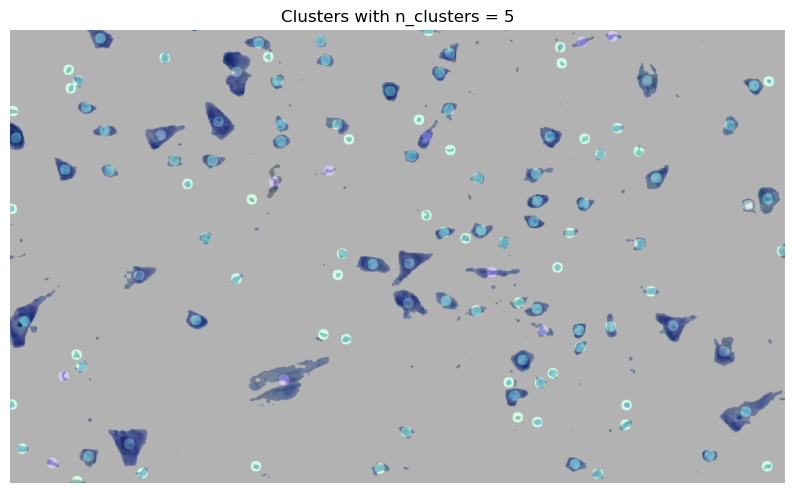


Processing for n_clusters = 6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Silhouette Score for 6 clusters: 0.181


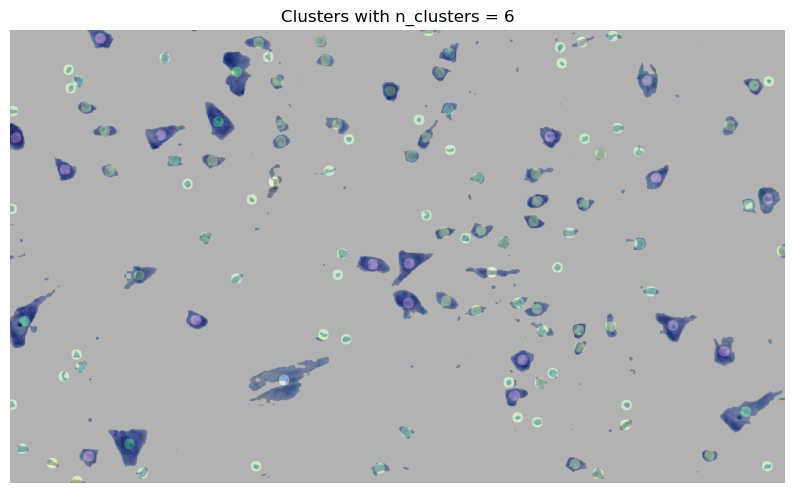


Processing for n_clusters = 7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Silhouette Score for 7 clusters: 0.228


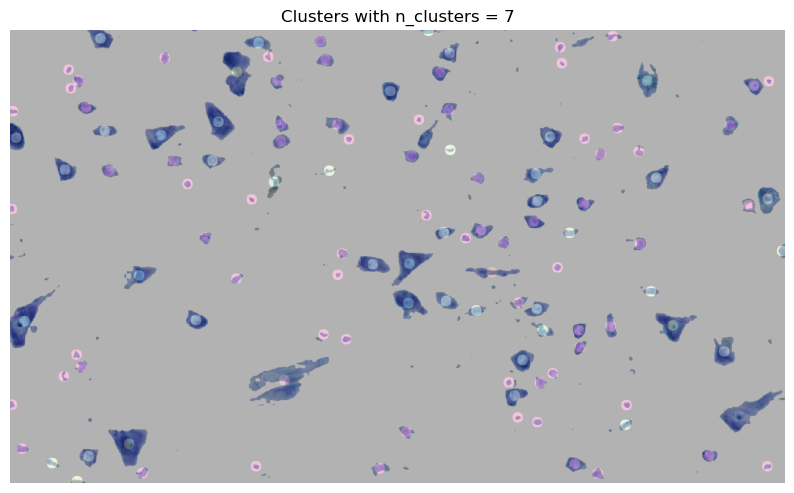


Processing for n_clusters = 8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Silhouette Score for 8 clusters: 0.182


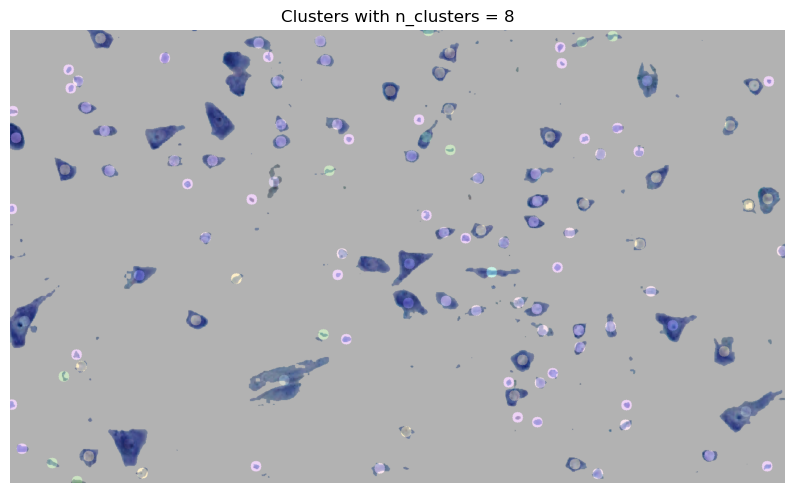


Processing for n_clusters = 9
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Silhouette Score for 9 clusters: 0.229


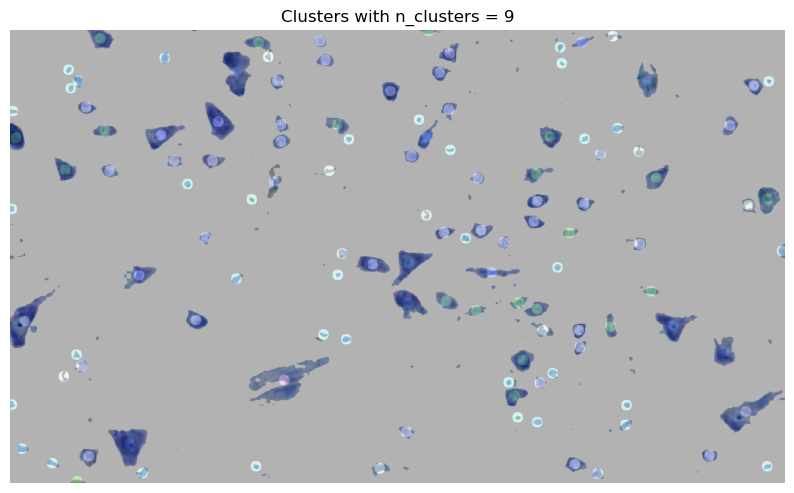


Processing for n_clusters = 10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Silhouette Score for 10 clusters: 0.239


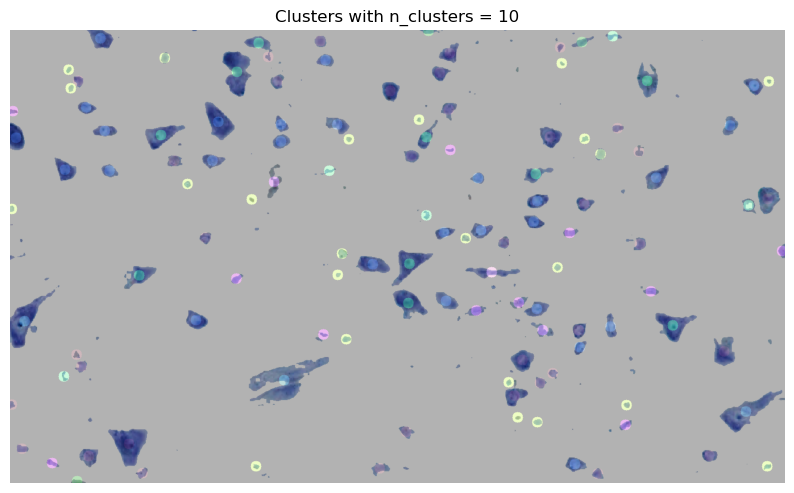

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import StandardScaler
import random

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load clustering data
clustering_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Replace with your actual path
df = pd.read_csv(clustering_csv)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)

# Identify feature columns with correct casing
solidity_col = 'Solidity'  # Note the uppercase 'S'
circularity_col = 'Circularity'  # Note the uppercase 'C'
local_homogeneity_col = 'Local Homogeneity'  # Note the uppercase 'L' and 'H'

# Scale features to adjust weightage
solidity_scaling_factor = 4  # Adjust this factor to achieve the desired weightage
circularity_scaling_factor = 4  # Adjust this factor to achieve the desired weightage
local_homogeneity_scaling_factor = 2.4  # Adjust this factor to achieve the desired weightage

df[solidity_col] *= solidity_scaling_factor
df[circularity_col] *= circularity_scaling_factor
df[local_homogeneity_col] *= local_homogeneity_scaling_factor

# Normalize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(df.values.astype(np.float32))
input_dim = X.shape[1]

# Load centroid data
centroid_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"  # Replace with your actual path
centroid_df = pd.read_csv(centroid_csv)

# Load original image
image_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\restored_white_background_debug-Copy1.png"  # Replace with your actual path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define contrastive learning model
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation=None)(x)
    model = models.Model(inputs, latent, name="encoder")
    return model

def build_projection_head(latent_dim, projection_dim=32):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    outputs = layers.Dense(projection_dim, activation=None)(x)
    model = models.Model(inputs, outputs, name="projection")
    return model

def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    similarities = tf.matmul(z1, z2, transpose_b=True) / temperature
    labels = tf.range(tf.shape(z1)[0])
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, similarities, from_logits=True)
    return tf.reduce_mean(loss)

def train_contrastive_encoder(X, latent_dim, epochs=30, batch_size=64, temperature=0.5):
    encoder = build_encoder(latent_dim)
    projection = build_projection_head(latent_dim)
    optimizer = optimizers.Adam(learning_rate=0.001)
    dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1024).batch(batch_size)
    
    for epoch in range(epochs):
        for batch in dataset:
            x1 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            x2 = batch.numpy() + np.random.normal(0, 0.01, batch.shape)
            with tf.GradientTape() as tape:
                z1 = encoder(x1, training=True)
                z2 = encoder(x2, training=True)
                p1 = projection(z1, training=True)
                p2 = projection(z2, training=True)
                loss = nt_xent_loss(p1, p2, temperature=temperature)
            gradients = tape.gradient(loss, encoder.trainable_variables + projection.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projection.trainable_variables))
    return encoder

# Iterate over the desired number of clusters
for n_clusters in range(5, 11):
    print(f"\nProcessing for n_clusters = {n_clusters}")

    # Train the contrastive encoder
    latent_dim = 12  # Adjust as needed
    encoder = train_contrastive_encoder(X, latent_dim=latent_dim)
    latent_repr = encoder.predict(X)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(latent_repr)

    # Compute silhouette score
    sil_score = silhouette_score(latent_repr, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {sil_score:.3f}")

    # Overlay clusters onto image (FULL CELL COLORING)
    colors = np.random.randint(0, 255, size=(n_clusters, 3), dtype=np.uint8)
    mask = np.zeros_like(image, dtype=np.uint8)

    for i, row in centroid_df.iterrows():
        x, y = int(row['X Centroid']), int(row['Y Centroid'])
        cluster = labels[i]
        color = tuple(int(c) for c in colors[cluster])
        cv2.circle(mask, (x, y), 10, color, -1)  # Adjust the radius as needed

    overlay = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    # Display the overlay
    plt.figure(figsize=(10, 10))
    plt.title(f'Clusters with n_clusters = {n_clusters}')
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

 ### Feature-Engineered K-Means Clustering Model

In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Assign feature weights
feature_weights = {
    "Solidity": 3,
    "Circularity": 3,
    "Local_Homogeneity": 3,
    "Aspect Ratio": 3
}

# Apply weights to selected features
df_weighted = df.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)  
dim_features = features.shape[1]

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

# Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = torch.norm(anchor - positive, p=2, dim=1)
        neg_distance = torch.norm(anchor - negative, p=2, dim=1)
        loss = torch.clamp(pos_distance - neg_distance + self.margin, min=0.0)
        return torch.mean(loss)

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop for contrastive clustering
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Randomly sample triplets: anchor, positive, and negative samples
    idx = torch.randperm(features_tensor.size(0))  # Shuffle indices
    anchor = features_tensor[idx]
    positive = features_tensor[idx]  # Example: sampling positive samples
    negative = features_tensor[torch.roll(idx, shifts=1)]  # Negative samples
    
    # Get embeddings
    anchor_embed = model(anchor)
    positive_embed = model(positive)
    negative_embed = model(negative)
    
    # Calculate Triplet Loss
    loss = criterion(anchor_embed, positive_embed, negative_embed)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Apply UMAP for dimensionality reduction to 2D
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Results storage
results = []

# Clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=20)  # Increased n_init for stability
    labels = kmeans.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, labels)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = np.mean(c1, axis=0)
        c2_mean = np.mean(c2, axis=0)
        
        # Regularize the probabilities to avoid zeros in JS calculation
        c1_mean = np.clip(c1_mean, 1e-10, 1.0 - 1e-10)
        c2_mean = np.clip(c2_mean, 1e-10, 1.0 - 1e-10)
        
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")

    # Stability Score (variance of cluster assignments)
    stability = (1 - np.var(labels) / (n * n)) * 100
    
    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Print the results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")


n = 2, Stability Score = 93.75%, Silhouette Score = 0.541, Mean JS Distance = 0.465
n = 3, Stability Score = 93.10%, Silhouette Score = 0.674, Mean JS Distance = 0.310
n = 4, Stability Score = 92.46%, Silhouette Score = 0.634, Mean JS Distance = 0.298
n = 5, Stability Score = 92.48%, Silhouette Score = 0.643, Mean JS Distance = 0.394
n = 6, Stability Score = 91.18%, Silhouette Score = 0.600, Mean JS Distance = 0.402
n = 7, Stability Score = 91.44%, Silhouette Score = 0.598, Mean JS Distance = 0.361
n = 8, Stability Score = 91.08%, Silhouette Score = 0.589, Mean JS Distance = 0.347
n = 9, Stability Score = 92.16%, Silhouette Score = 0.615, Mean JS Distance = 0.327
n = 10, Stability Score = 92.14%, Silhouette Score = 0.621, Mean JS Distance = 0.332


### Autoencoder-Based Contrastive Clustering Feature Engineering 

In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Ignore warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Assign feature weights
feature_weights = {
    "Solidity": 3,
    "Circularity": 3,
    "Local_Homogeneity": 3,
    "Aspect Ratio": 3
}

# Apply weights to selected features
df_weighted = df.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix (Assuming first column is non-feature like ID)
features = df_weighted.iloc[:, 1:].values.astype(np.float32)  
dim_features = features.shape[1]  # Get feature count

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Function to regularize probabilities and avoid zero values in Jensen-Shannon calculation
def regularize_probabilities(probabilities, epsilon=1e-10):
    return np.clip(probabilities, epsilon, 1.0 - epsilon)

# Initialize result storage
results = []
stability_scores = []
silhouette_scores = []
mean_js_distances = []

# Run KMeans clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = np.mean(c1, axis=0)
        c2_mean = np.mean(c2, axis=0)
        
        # Ensure that the probability distributions are regularized
        c1_mean = regularize_probabilities(c1_mean)
        c2_mean = regularize_probabilities(c2_mean)
        
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
    mean_js_distances.append(mean_js_distance)
    
    # Stability Score (variance of cluster assignments)
    stability = (1 - np.var(labels) / (n * n)) * 100
    stability_scores.append(stability)

    # Save clustering result and image for each n
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='viridis')
    ax.set_title(f'Clusters for n = {n}')
    plt.savefig(f"cluster_overlay_n{n}.png")
    plt.close()

    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Plotting the results
# Box plot for stability
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Scores")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability")
plt.savefig("stability_box_plot.png")
plt.close()

# Stability box plot (focus on stability)
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Box Plot")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability")
plt.savefig("stability_box_plot_focus.png")
plt.close()

# Line graph with Silhouette Score and Mean JS Distance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.plot(np.arange(2, 11), mean_js_distances, label="Mean JS Distance", marker='o')
plt.title("Silhouette Score and Mean JS Distance")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.savefig("silhouette_js_line_graph.png")
plt.close()

# Print final clustering results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")


n = 2, Stability Score = 93.90%, Silhouette Score = 0.669, Mean JS Distance = 0.000
n = 3, Stability Score = 93.63%, Silhouette Score = 0.842, Mean JS Distance = 0.310
n = 4, Stability Score = 92.94%, Silhouette Score = 0.747, Mean JS Distance = 0.232
n = 5, Stability Score = 91.40%, Silhouette Score = 0.756, Mean JS Distance = 0.186
n = 6, Stability Score = 93.03%, Silhouette Score = 0.748, Mean JS Distance = 0.155
n = 7, Stability Score = 92.10%, Silhouette Score = 0.665, Mean JS Distance = 0.133
n = 8, Stability Score = 91.57%, Silhouette Score = 0.646, Mean JS Distance = 0.116
n = 9, Stability Score = 92.57%, Silhouette Score = 0.649, Mean JS Distance = 0.103
n = 10, Stability Score = 92.21%, Silhouette Score = 0.633, Mean JS Distance = 0.093


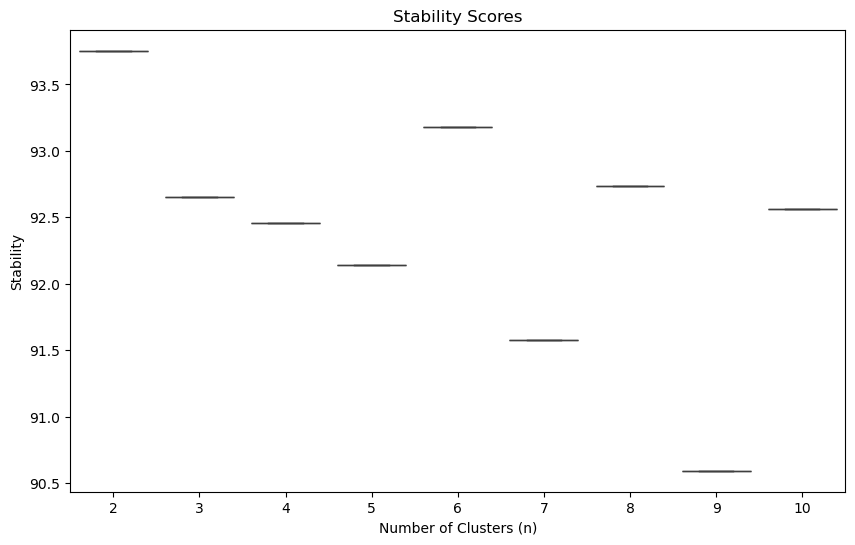

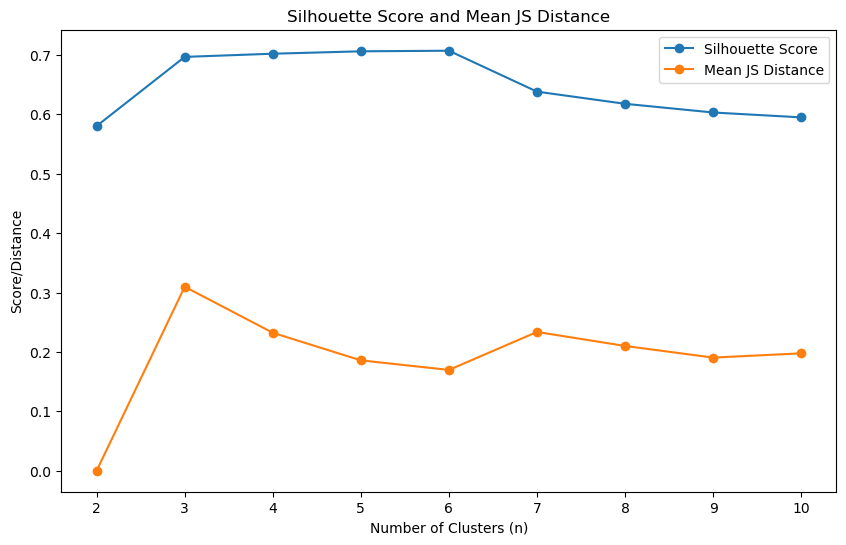

n = 2, Stability Score = 93.75%, Silhouette Score = 0.580, Mean JS Distance = 0.000
n = 3, Stability Score = 92.65%, Silhouette Score = 0.697, Mean JS Distance = 0.310
n = 4, Stability Score = 92.46%, Silhouette Score = 0.702, Mean JS Distance = 0.232
n = 5, Stability Score = 92.14%, Silhouette Score = 0.706, Mean JS Distance = 0.186
n = 6, Stability Score = 93.18%, Silhouette Score = 0.707, Mean JS Distance = 0.170
n = 7, Stability Score = 91.57%, Silhouette Score = 0.638, Mean JS Distance = 0.234
n = 8, Stability Score = 92.74%, Silhouette Score = 0.618, Mean JS Distance = 0.210
n = 9, Stability Score = 90.59%, Silhouette Score = 0.603, Mean JS Distance = 0.190
n = 10, Stability Score = 92.56%, Silhouette Score = 0.595, Mean JS Distance = 0.198


In [49]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from PIL import Image

# Ignore warnings
warnings.filterwarnings("ignore")

# Load the dataset (replace with actual file paths)
df = pd.read_csv("data_with_cluster_labels_Contrastive Clustering.csv")

# Assign feature weights (assuming the appropriate columns exist)
feature_weights = {
    "Solidity": 3,
    "Circularity": 3,
    "Local_Homogeneity": 3,
    "Aspect Ratio": 3
}

# Apply weights to selected features
df_weighted = df.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix (assuming the first column is non-feature like ID)
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]  # Get feature count

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Load the original image (Nissl-stained brain image)
original_image_path = "restored_white_background_debug-Copy1.png"  # Update with your image path
original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")

# Function to regularize probabilities and avoid zero values in Jensen-Shannon calculation
def regularize_probabilities(probabilities, epsilon=1e-10):
    return np.clip(probabilities, epsilon, 1.0 - epsilon)

# Initialize result storage
results = []
stability_scores = []
silhouette_scores = []
mean_js_distances = []

# Run KMeans clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = np.mean(c1, axis=0)
        c2_mean = np.mean(c2, axis=0)
        
        # Ensure that the probability distributions are regularized
        c1_mean = regularize_probabilities(c1_mean)
        c2_mean = regularize_probabilities(c2_mean)
        
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
    mean_js_distances.append(mean_js_distance)
    
    # Stability Score (variance of cluster assignments)
    stability = (1 - np.var(labels) / (n * n)) * 100
    stability_scores.append(stability)

    # Plot the original image with the overlay of clusters for each value of n
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image, aspect='auto')
    ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)
    ax.set_title(f'Clusters for n = {n}')
    plt.savefig(f"cluster_overlay_n{n}.png")
    plt.close()

    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Save results to CSV with cluster labels
df['Cluster'] = kmeans.labels_
df.to_csv('data_with_clusters.csv', index=False)

# Plotting the results
# Box plot for stability
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Scores")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability")
plt.savefig("stability_box_plot.png")
plt.show()

# Line graph with Silhouette Score and Mean JS Distance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.plot(np.arange(2, 11), mean_js_distances, label="Mean JS Distance", marker='o')
plt.title("Silhouette Score and Mean JS Distance")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.savefig("silhouette_js_line_graph.png")
plt.show()

# Print final clustering results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")


In [51]:
import pandas as pd

# Load the feature dataset (CSV with features for clustering)
df_features = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Load the centroid dataset (CSV with features + centroids)
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv")

# Display the columns of the feature dataset
print("Columns in the feature dataset (for clustering):")
print(df_features.columns)

# Display the columns of the centroid dataset
print("\nColumns in the centroid dataset (for centroids):")
print(df_centroids.columns)


Columns in the feature dataset (for clustering):
Index(['Cell Number', 'Area', 'Perimeter', 'Major Axis Length',
       'Minor Axis Length', 'Soma Diameter', 'Aspect Ratio', 'Circularity',
       'Solidity', 'Local Homogeneity'],
      dtype='object')

Columns in the centroid dataset (for centroids):
Index(['Cell Number', 'Cell Type', 'Area', 'Perimeter', 'Major Axis Length',
       'Minor Axis Length', 'Soma Diameter', 'Aspect Ratio', 'Circularity',
       'Solidity', 'Nucleolus Present', 'X Centroid', 'Y Centroid'],
      dtype='object')


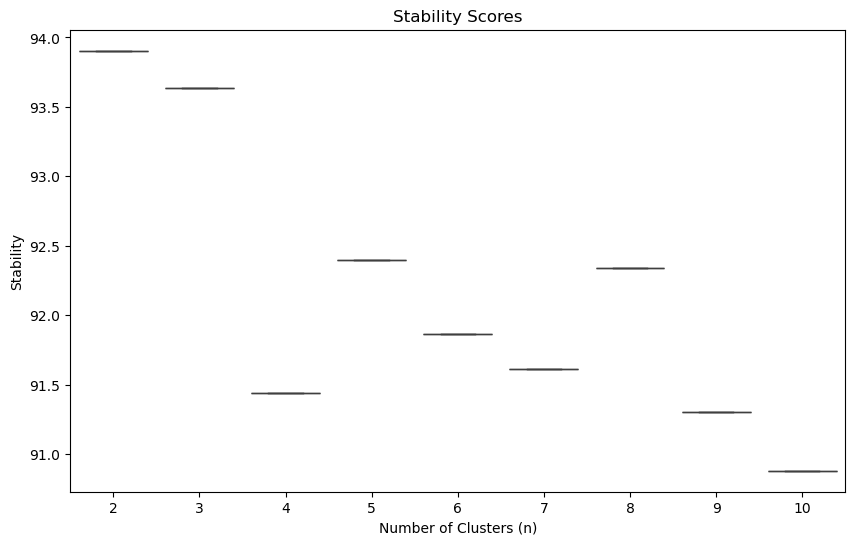

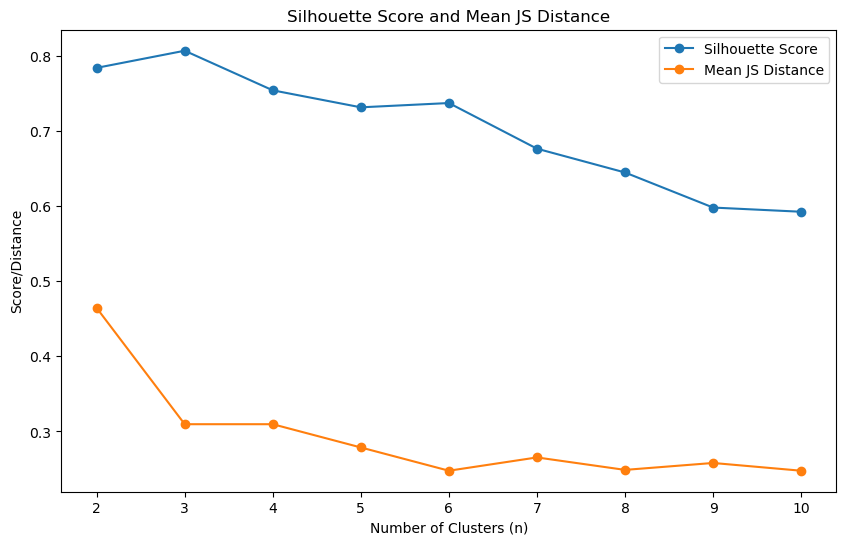

n = 2, Stability Score = 93.90%, Silhouette Score = 0.784, Mean JS Distance = 0.465
n = 3, Stability Score = 93.63%, Silhouette Score = 0.807, Mean JS Distance = 0.310
n = 4, Stability Score = 91.44%, Silhouette Score = 0.754, Mean JS Distance = 0.310
n = 5, Stability Score = 92.40%, Silhouette Score = 0.732, Mean JS Distance = 0.279
n = 6, Stability Score = 91.86%, Silhouette Score = 0.737, Mean JS Distance = 0.248
n = 7, Stability Score = 91.62%, Silhouette Score = 0.677, Mean JS Distance = 0.265
n = 8, Stability Score = 92.34%, Silhouette Score = 0.645, Mean JS Distance = 0.249
n = 9, Stability Score = 91.30%, Silhouette Score = 0.598, Mean JS Distance = 0.258
n = 10, Stability Score = 90.88%, Silhouette Score = 0.593, Mean JS Distance = 0.248


In [55]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from PIL import Image

# Ignore warnings
warnings.filterwarnings("ignore")

# Load the feature dataset (for clustering)
df_features = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Load the centroid dataset (for centroids)
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv")

# Apply weights to selected features (for clustering)
feature_weights = {
    "Solidity": 3,
    "Circularity": 3,
    "Local Homogeneity": 3,
    "Aspect Ratio": 3
}

# Apply weights to features
df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix (Assuming first column is non-feature like ID)
features = df_weighted.iloc[:, 1:].values.astype(np.float32)  # Removing 'Cell Number'
dim_features = features.shape[1]  # Get feature count

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Function to regularize probabilities and avoid zero values in Jensen-Shannon calculation
def regularize_probabilities(probabilities, epsilon=1e-10):
    return np.clip(probabilities, epsilon, 1.0 - epsilon)

# Load the original image (Nissl-stained brain image)
original_image_path = "restored_white_background_debug-Copy1.png"  # Update with your image path
original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")

# Initialize result storage
results = []
stability_scores = []
silhouette_scores = []
mean_js_distances = []

# Run KMeans clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = np.mean(c1, axis=0)
        c2_mean = np.mean(c2, axis=0)
        
        # Ensure that the probability distributions are regularized
        c1_mean = regularize_probabilities(c1_mean)
        c2_mean = regularize_probabilities(c2_mean)
        
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
    mean_js_distances.append(mean_js_distance)
    
    # Stability Score (variance of cluster assignments)
    stability = (1 - np.var(labels) / (n * n)) * 100
    stability_scores.append(stability)

    # Plot the original image with the overlay of clusters for each value of n
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image, aspect='auto')

    # Overlay centroids based on the centroid CSV for the current clusters
    centroid_df = df_centroids[['Cell Number', 'X Centroid', 'Y Centroid']]
    centroid_df['Cluster'] = labels
    
    # Match the clusters with centroid coordinates
    for i in range(n):
        cluster_centroids = centroid_df[centroid_df['Cluster'] == i]
        ax.scatter(cluster_centroids['X Centroid'], cluster_centroids['Y Centroid'], label=f'Cluster {i+1}')
    
    ax.set_title(f'Clusters for n = {n}')
    ax.legend(loc='upper right')
    plt.savefig(f"cluster_overlay_n{n}.png")
    plt.close()

    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Plotting the results
# Box plot for stability
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Scores")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability")
plt.show()

# Line graph with Silhouette Score and Mean JS Distance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.plot(np.arange(2, 11), mean_js_distances, label="Mean JS Distance", marker='o')
plt.title("Silhouette Score and Mean JS Distance")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.show()

# Print final clustering results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")


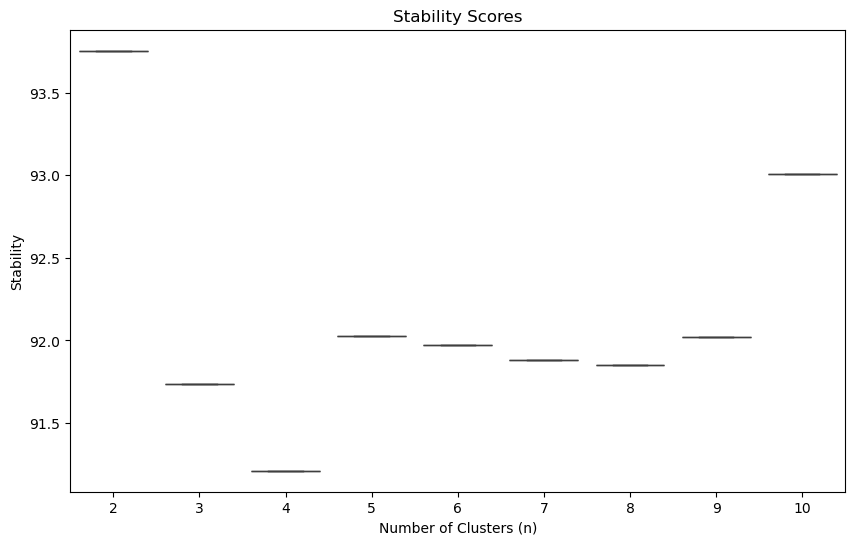

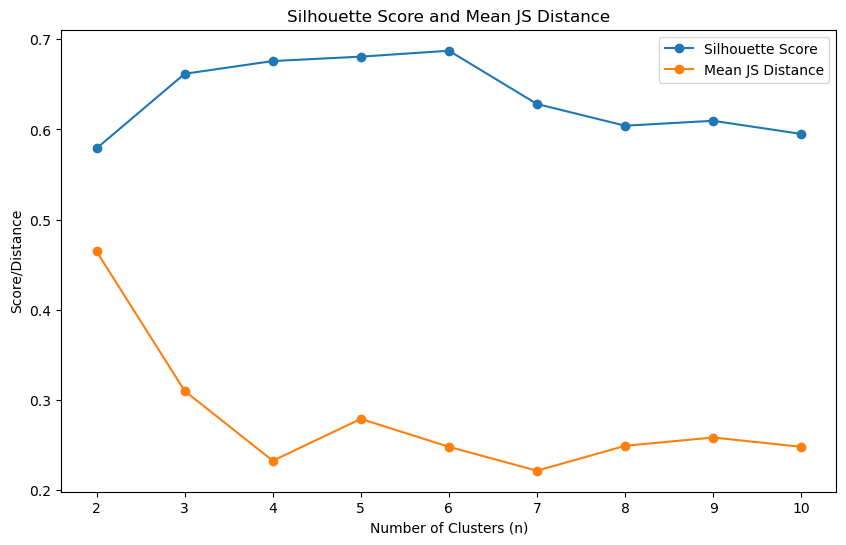

n = 2, Stability Score = 93.75%, Silhouette Score = 0.579, Mean JS Distance = 0.465
n = 3, Stability Score = 91.74%, Silhouette Score = 0.662, Mean JS Distance = 0.310
n = 4, Stability Score = 91.21%, Silhouette Score = 0.676, Mean JS Distance = 0.232
n = 5, Stability Score = 92.03%, Silhouette Score = 0.681, Mean JS Distance = 0.279
n = 6, Stability Score = 91.97%, Silhouette Score = 0.687, Mean JS Distance = 0.248
n = 7, Stability Score = 91.88%, Silhouette Score = 0.628, Mean JS Distance = 0.221
n = 8, Stability Score = 91.85%, Silhouette Score = 0.604, Mean JS Distance = 0.249
n = 9, Stability Score = 92.02%, Silhouette Score = 0.610, Mean JS Distance = 0.258
n = 10, Stability Score = 93.01%, Silhouette Score = 0.595, Mean JS Distance = 0.248


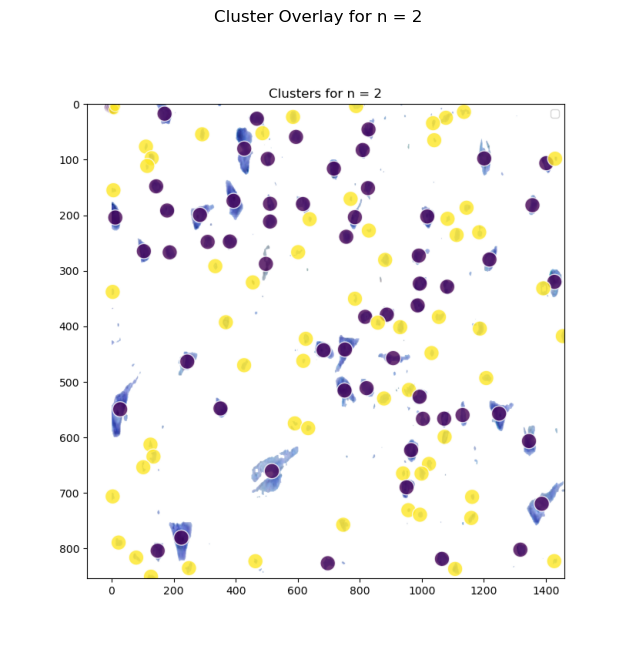

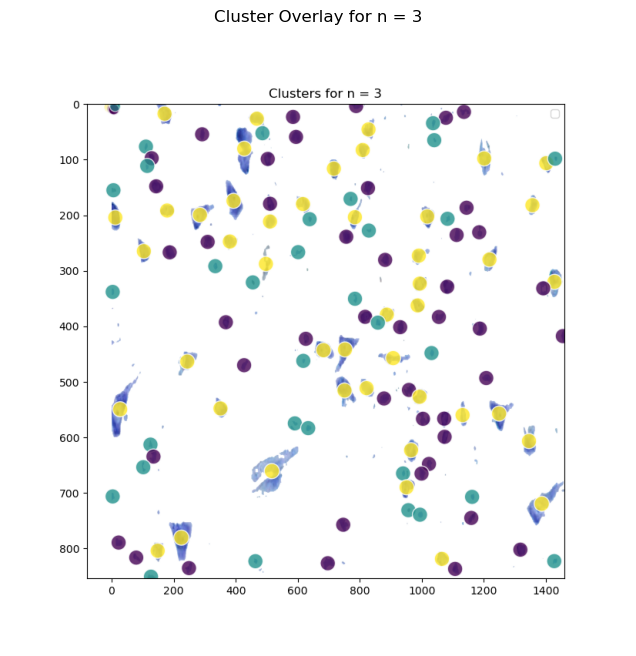

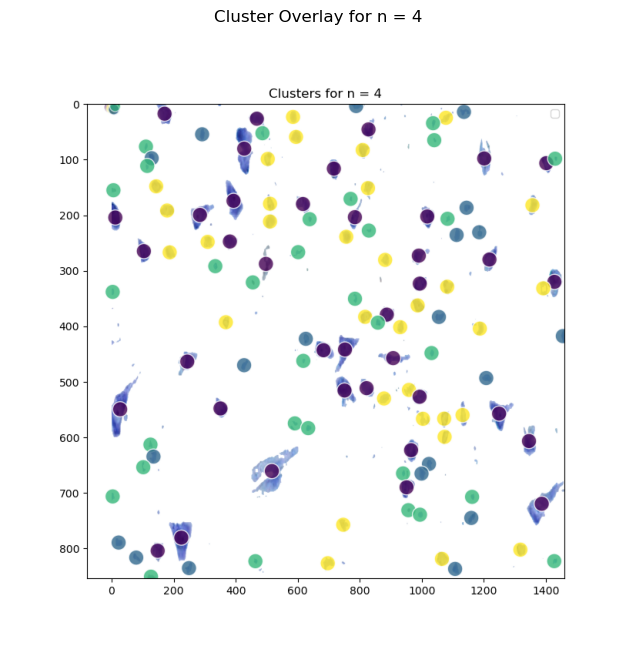

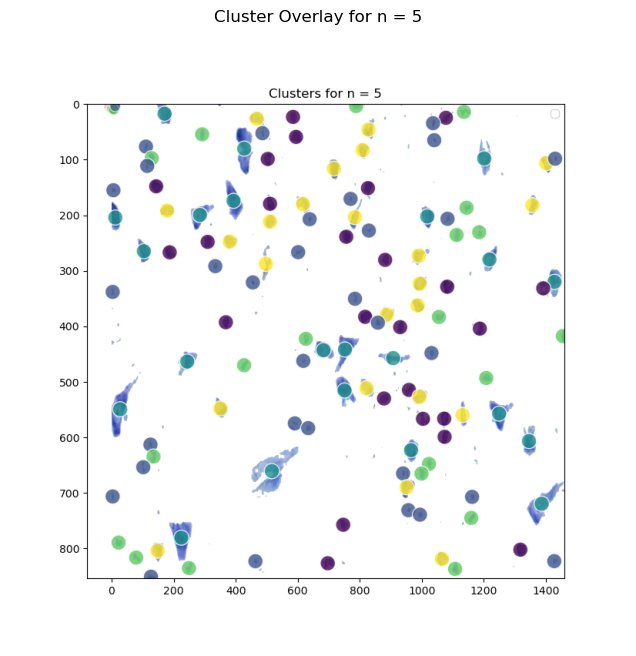

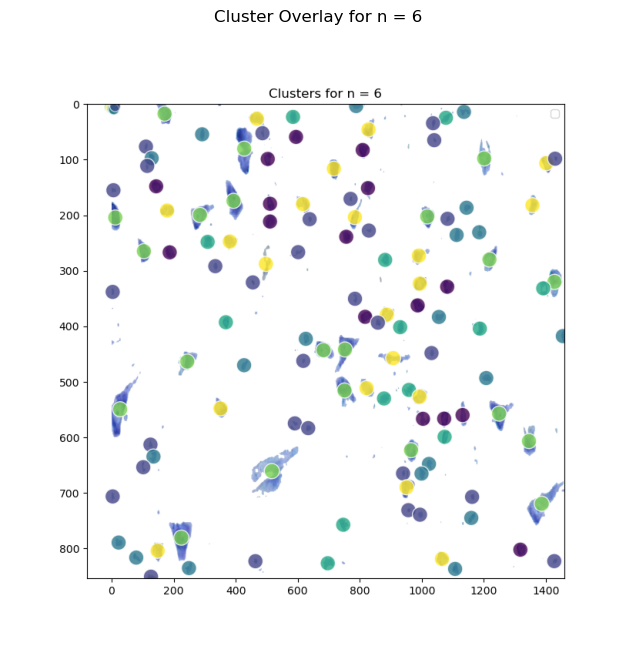

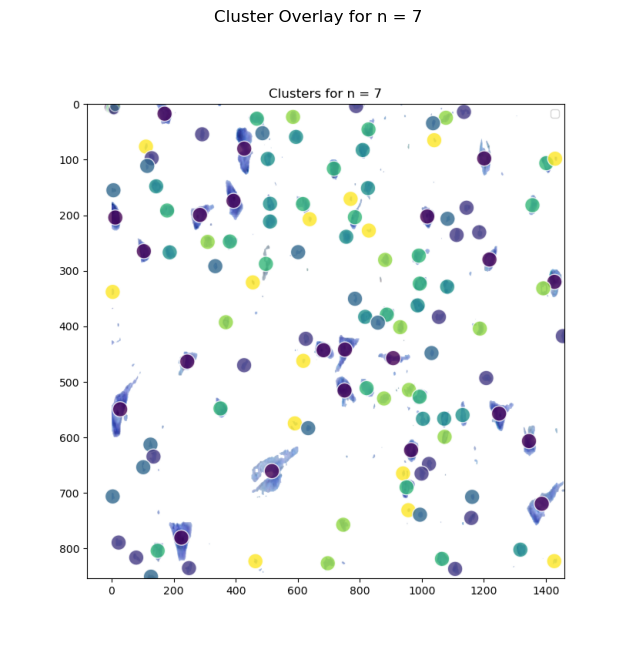

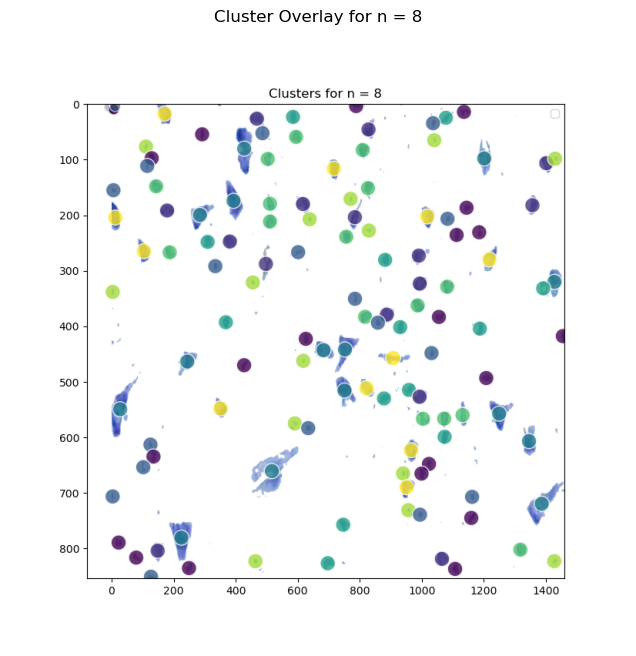

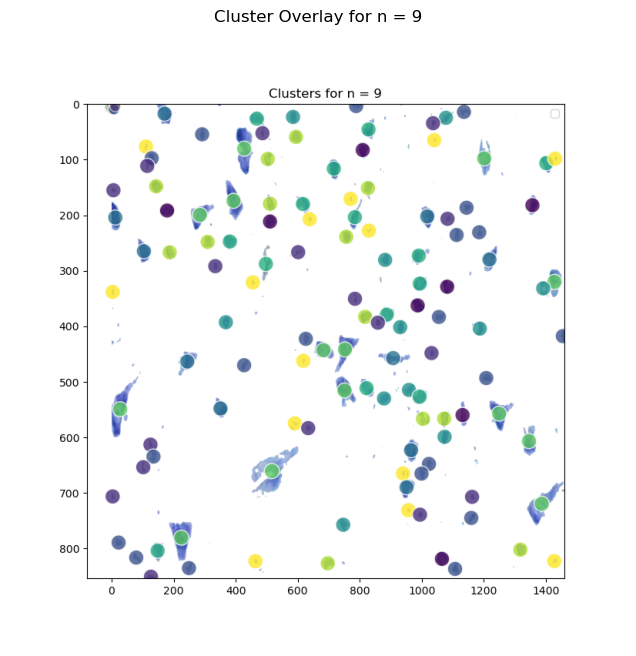

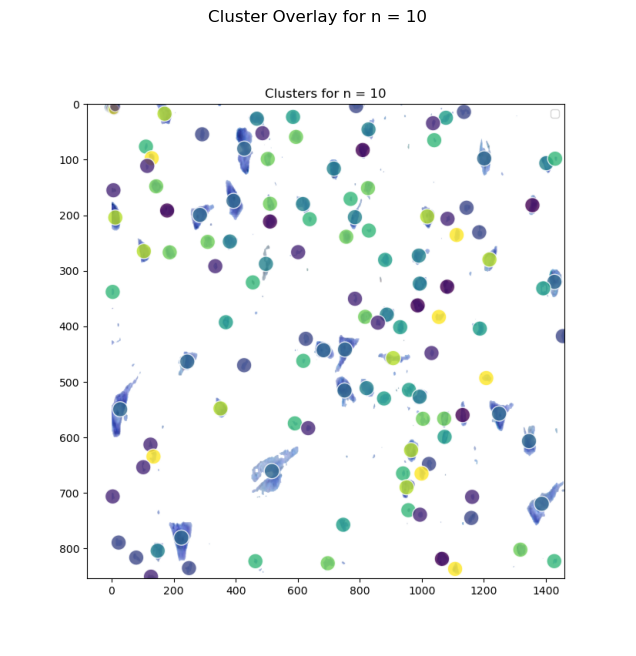

In [59]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.image as mpimg

# Ignore warnings
warnings.filterwarnings("ignore")

# Load dataset (Feature data for clustering)
df_features = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Load dataset (Centroid data to plot centroids)
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv")  # Update with your centroid dataset path

# Assign feature weights
feature_weights = {
    "Solidity": 3,
    "Circularity": 3,
    "Local_Homogeneity": 3,
    "Aspect Ratio": 3
}

# Apply weights to selected features
df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix (Assuming first column is non-feature like ID)
features = df_weighted.iloc[:, 1:].values.astype(np.float32)  
dim_features = features.shape[1]  # Get feature count

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Function to regularize probabilities and avoid zero values in Jensen-Shannon calculation
def regularize_probabilities(probabilities, epsilon=1e-10):
    return np.clip(probabilities, epsilon, 1.0 - epsilon)

# Load the original image (Nissl-stained brain image)
original_image_path = "restored_white_background_debug-Copy1.png"  # Update with your image path
original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")

# Initialize result storage
results = []
stability_scores = []
silhouette_scores = []
mean_js_distances = []

# Run KMeans clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = np.mean(c1, axis=0)
        c2_mean = np.mean(c2, axis=0)
        
        # Ensure that the probability distributions are regularized
        c1_mean = regularize_probabilities(c1_mean)
        c2_mean = regularize_probabilities(c2_mean)
        
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
    mean_js_distances.append(mean_js_distance)
    
    # Stability Score (variance of cluster assignments)
    stability = (1 - np.var(labels) / (n * n)) * 100
    stability_scores.append(stability)

    # Overlaying the clusters on the original image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image, aspect='auto')
    
    # Plot clusters with labels in the corresponding colors
    scatter = ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolors='w', s=100)
    
    # Get centroid locations from the centroid dataset
    centroid_data = df_centroids[df_centroids['Cell Number'].isin(df_features['Cell Number'])]

    # Plot centroids with their respective colors based on the clusters
    ax.scatter(centroid_data['X Centroid'], centroid_data['Y Centroid'], c=labels, cmap='viridis', marker='o', edgecolors='w', s=200, alpha=0.8)

    ax.set_title(f'Clusters for n = {n}')
    ax.legend(loc='best')
    plt.savefig(f"cluster_overlay_n{n}.png")
    plt.close()

    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Plotting the results
# Box plot for stability
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Scores")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability")
plt.show()

# Line graph with Silhouette Score and Mean JS Distance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.plot(np.arange(2, 11), mean_js_distances, label="Mean JS Distance", marker='o')
plt.title("Silhouette Score and Mean JS Distance")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.show()

# Print final clustering results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")

# Display each saved image in the notebook
for n in range(2, 11):
    img_path = f"cluster_overlay_n{n}.png"
    img = mpimg.imread(img_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Cluster Overlay for n = {n}")
    plt.axis('off')  # Optional: to hide axes for better visualization
    plt.show()


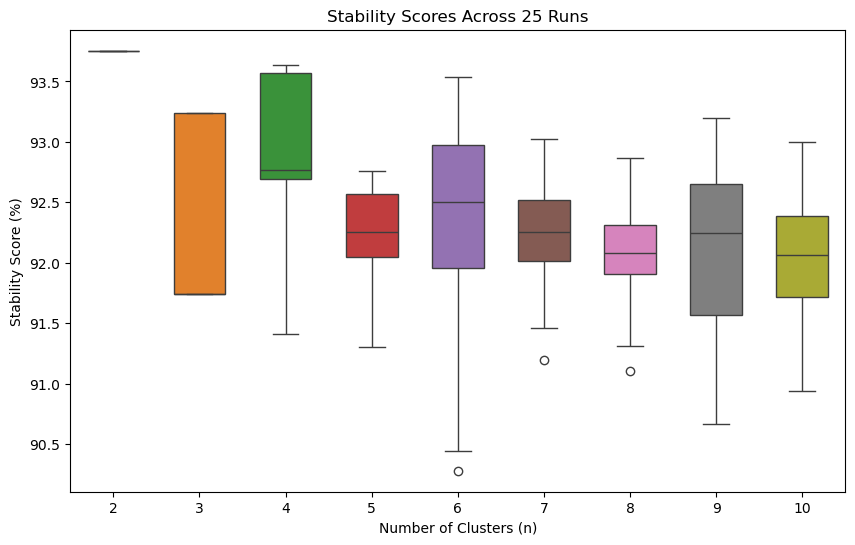

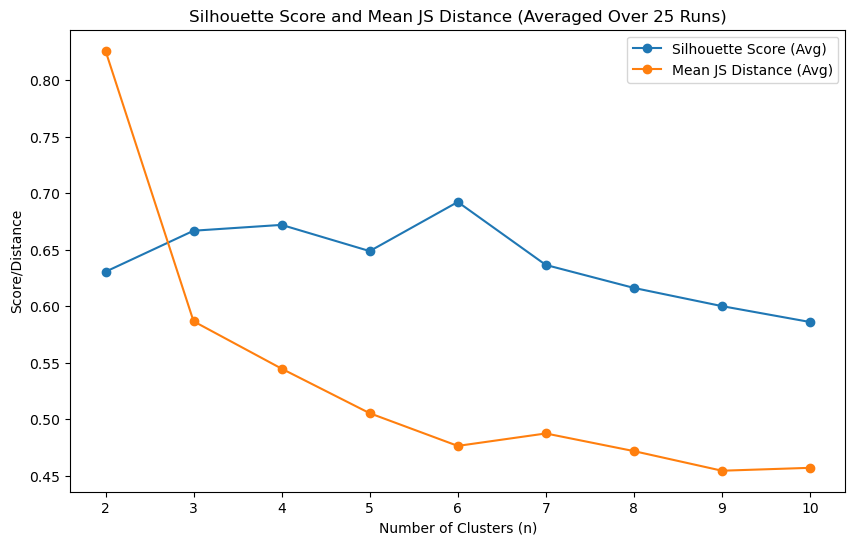


Final Clustering Results (Averaged Over 25 Runs):
n = 2, Stability Score = 93.75%, Silhouette Score = 0.631, Mean JS Distance = 0.826
n = 3, Stability Score = 92.44%, Silhouette Score = 0.667, Mean JS Distance = 0.587
n = 4, Stability Score = 92.88%, Silhouette Score = 0.672, Mean JS Distance = 0.545
n = 5, Stability Score = 92.24%, Silhouette Score = 0.649, Mean JS Distance = 0.505
n = 6, Stability Score = 92.28%, Silhouette Score = 0.692, Mean JS Distance = 0.476
n = 7, Stability Score = 92.21%, Silhouette Score = 0.637, Mean JS Distance = 0.487
n = 8, Stability Score = 92.06%, Silhouette Score = 0.616, Mean JS Distance = 0.472
n = 9, Stability Score = 92.09%, Silhouette Score = 0.600, Mean JS Distance = 0.454
n = 10, Stability Score = 92.03%, Silhouette Score = 0.586, Mean JS Distance = 0.457


In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from PIL import Image
import matplotlib.image as mpimg

# Ignore warnings
warnings.filterwarnings("ignore")

# Load dataset
df_features = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Feature weights
feature_weights = {
    "Solidity": 3,
    "Circularity": 3,
    "Local_Homogeneity": 3,
    "Aspect Ratio": 3
}

# Apply weights
df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)  
dim_features = features.shape[1]  

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.05, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Initialize result storage
stability_scores_all_runs = {n: [] for n in range(2, 11)}
silhouette_scores_all_runs = {n: [] for n in range(2, 11)}
mean_js_distances_all_runs = {n: [] for n in range(2, 11)}

# Run KMeans clustering for 25 runs for each k
for run in range(25):
    for n in range(2, 11):
        kmeans = KMeans(n_clusters=n, random_state=run, n_init=10)
        labels = kmeans.fit_predict(umap_embeddings)

        # Silhouette Score
        silhouette = silhouette_score(umap_embeddings, labels)
        silhouette_scores_all_runs[n].append(silhouette)

        # Jensen-Shannon Distance
        clusters = [umap_embeddings[labels == i, :] for i in range(n)]
        js_distances = []
        for c1, c2 in combinations(clusters, 2):
            c1_mean = softmax(np.mean(c1, axis=0))  # Apply Softmax
            c2_mean = softmax(np.mean(c2, axis=0))  # Apply Softmax
            
            js_dist = jensenshannon(c1_mean, c2_mean)
            js_distances.append(js_dist)

        mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
        mean_js_distances_all_runs[n].append(mean_js_distance)

        # Stability Score (variance of cluster assignments)
        stability = (1 - np.var(labels) / (n * n)) * 100
        stability_scores_all_runs[n].append(stability)

# Box plot for stability scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=[stability_scores_all_runs[n] for n in range(2, 11)], width=0.6)
plt.xticks(ticks=np.arange(0, 9), labels=np.arange(2, 11))
plt.title("Stability Scores Across 25 Runs")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability Score (%)")
plt.show()

# Line graph for Silhouette Score & Mean JS Distance
avg_silhouette_scores = [np.mean(silhouette_scores_all_runs[n]) for n in range(2, 11)]
avg_js_distances = [np.mean(mean_js_distances_all_runs[n]) for n in range(2, 11)]

plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), avg_silhouette_scores, label="Silhouette Score (Avg)", marker='o')
plt.plot(np.arange(2, 11), avg_js_distances, label="Mean JS Distance (Avg)", marker='o')
plt.title("Silhouette Score and Mean JS Distance (Averaged Over 25 Runs)")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.show()

# Print final clustering results
print("\nFinal Clustering Results (Averaged Over 25 Runs):")
for n in range(2, 11):
    avg_stability = np.mean(stability_scores_all_runs[n])
    avg_silhouette = np.mean(silhouette_scores_all_runs[n])
    avg_js_distance = np.mean(mean_js_distances_all_runs[n])
    print(f"n = {n}, Stability Score = {avg_stability:.2f}%, Silhouette Score = {avg_silhouette:.3f}, Mean JS Distance = {avg_js_distance:.3f}")


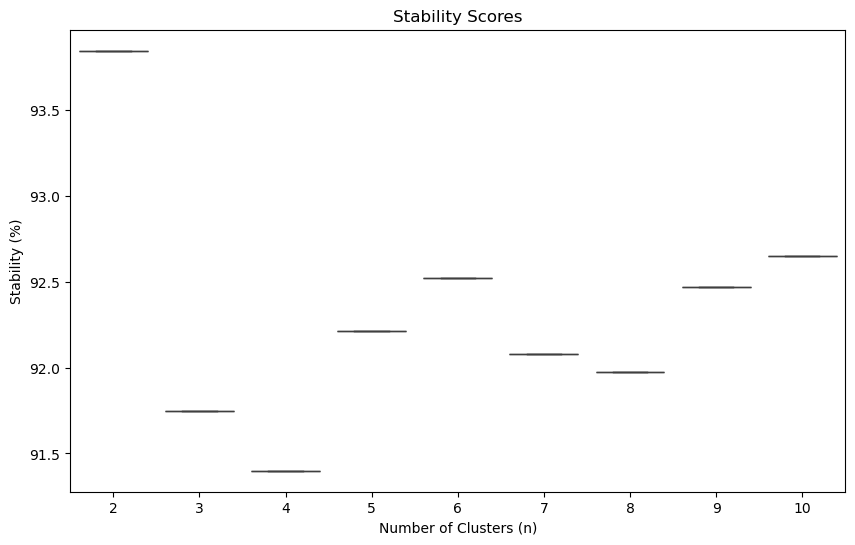

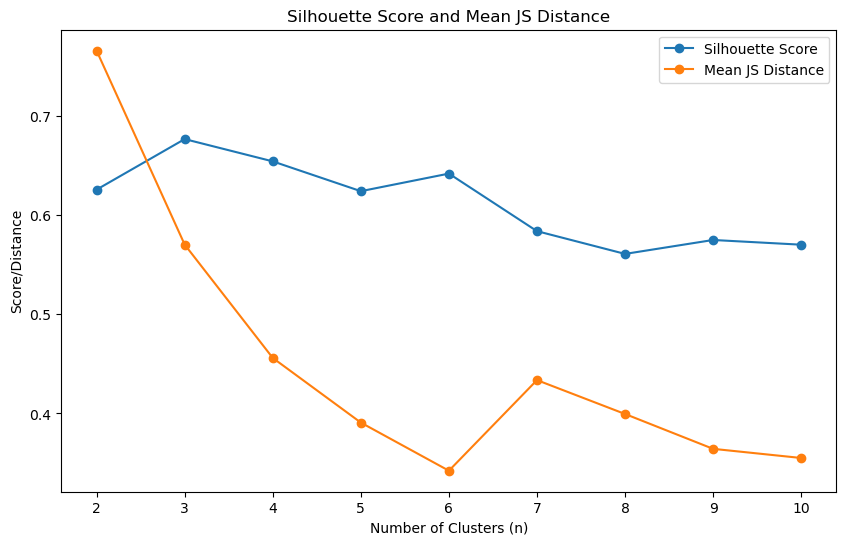

n = 2, Stability Score = 93.85%, Silhouette Score = 0.626, Mean JS Distance = 0.766
n = 3, Stability Score = 91.75%, Silhouette Score = 0.677, Mean JS Distance = 0.570
n = 4, Stability Score = 91.40%, Silhouette Score = 0.654, Mean JS Distance = 0.456
n = 5, Stability Score = 92.21%, Silhouette Score = 0.624, Mean JS Distance = 0.391
n = 6, Stability Score = 92.52%, Silhouette Score = 0.642, Mean JS Distance = 0.342
n = 7, Stability Score = 92.08%, Silhouette Score = 0.584, Mean JS Distance = 0.434
n = 8, Stability Score = 91.97%, Silhouette Score = 0.561, Mean JS Distance = 0.399
n = 9, Stability Score = 92.47%, Silhouette Score = 0.575, Mean JS Distance = 0.364
n = 10, Stability Score = 92.65%, Silhouette Score = 0.570, Mean JS Distance = 0.355


In [39]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

# Ignore warnings
warnings.filterwarnings("ignore")

# Load dataset (Feature data for clustering)
df_features = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Load dataset (Centroid data to plot centroids)
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv")  # Update with your centroid dataset path

# Assign feature weights
feature_weights = {
    "Solidity": 3,
    "Circularity": 3,
    "Local_Homogeneity": 3,
    "Aspect Ratio": 3
}

# Apply weights to selected features
df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix (Assuming first column is non-feature like ID)
features = df_weighted.iloc[:, 1:].values.astype(np.float32)  
dim_features = features.shape[1]  # Get feature count

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.05, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Function to apply Softmax normalization for Jensen-Shannon distance
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Load the original image (Nissl-stained brain image)
original_image_path = "restored_white_background_debug-Copy1.png"  # Update with your image path
original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")

# Initialize result storage
results = []
stability_scores = []
silhouette_scores = []
mean_js_distances = []

# Run KMeans clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = softmax(np.mean(c1, axis=0))
        c2_mean = softmax(np.mean(c2, axis=0))
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
    mean_js_distances.append(mean_js_distance)
    
    # Stability Score (variance of cluster assignments)
    stability = (1 - np.var(labels) / (n * n)) * 100
    stability_scores.append(stability)

    # Overlaying the clusters on the original image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image, aspect='auto')
    
    # Define a color map with distinct colors
    cmap = ListedColormap(sns.color_palette("tab10", n))
    scatter = ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, alpha=0.6, edgecolors='w', s=100)
    
    # Get centroid locations from the centroid dataset
    centroid_data = df_centroids[df_centroids['Cell Number'].isin(df_features['Cell Number'])]
    ax.scatter(centroid_data['X Centroid'], centroid_data['Y Centroid'], c=labels, cmap=cmap, marker='o', edgecolors='k', s=200, alpha=0.8)

    ax.set_title(f'Clusters for n = {n}')
    plt.savefig(f"cluster_overlay_n{n}.png")
    plt.close()

    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Box plot for stability
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Scores")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability (%)")
plt.show()

# Line graph with Silhouette Score and Mean JS Distance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.plot(np.arange(2, 11), mean_js_distances, label="Mean JS Distance", marker='o')
plt.title("Silhouette Score and Mean JS Distance")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.show()

# Print final clustering results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")

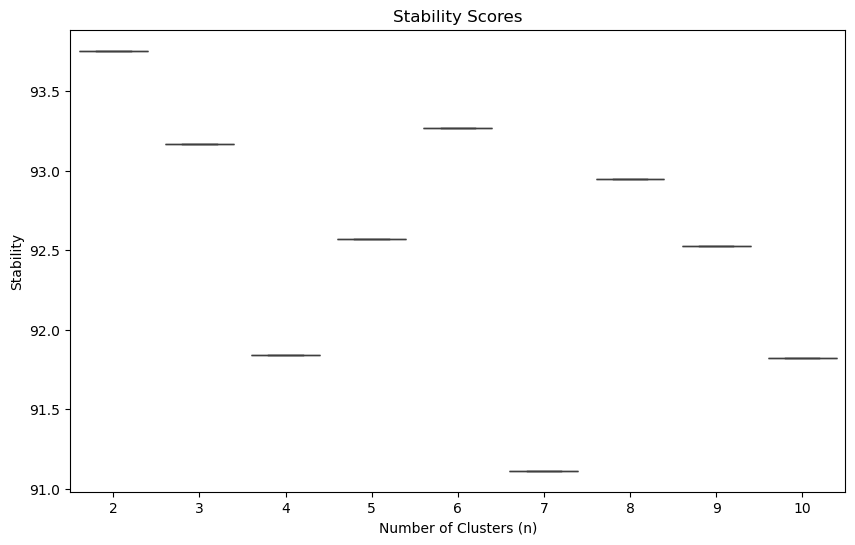

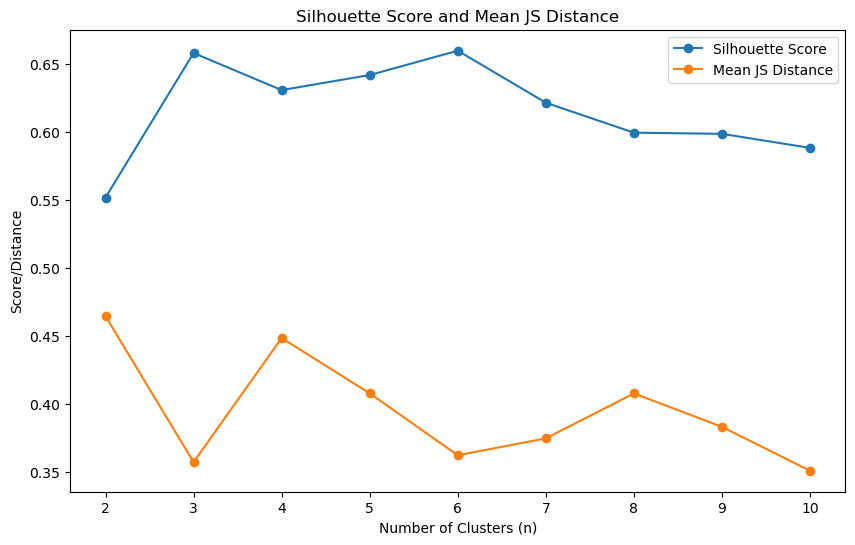

n = 2, Stability Score = 93.75%, Silhouette Score = 0.552, Mean JS Distance = 0.465
n = 3, Stability Score = 93.17%, Silhouette Score = 0.658, Mean JS Distance = 0.357
n = 4, Stability Score = 91.84%, Silhouette Score = 0.631, Mean JS Distance = 0.448
n = 5, Stability Score = 92.57%, Silhouette Score = 0.642, Mean JS Distance = 0.408
n = 6, Stability Score = 93.27%, Silhouette Score = 0.660, Mean JS Distance = 0.362
n = 7, Stability Score = 91.11%, Silhouette Score = 0.621, Mean JS Distance = 0.375
n = 8, Stability Score = 92.95%, Silhouette Score = 0.599, Mean JS Distance = 0.408
n = 9, Stability Score = 92.53%, Silhouette Score = 0.599, Mean JS Distance = 0.383
n = 10, Stability Score = 91.82%, Silhouette Score = 0.588, Mean JS Distance = 0.351


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from PIL import Image

# Ignore warnings
warnings.filterwarnings("ignore")

# Load the dataset (replace with actual file paths)
df = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Assign feature weights (assuming the appropriate columns exist)
feature_weights = {
    "Solidity": 6,
    "Circularity": 6,
    "Local_Homogeneity": 6,
    "Aspect Ratio": 6
}

# Apply weights to selected features
df_weighted = df.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix (assuming the first column is non-feature like ID)
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]  # Get feature count

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Load the original image (Nissl-stained brain image)
original_image_path = "restored_white_background_debug-Copy1.png"  # Update with your image path
original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")

# Function to regularize probabilities and avoid zero values in Jensen-Shannon calculation
def regularize_probabilities(probabilities, epsilon=1e-10):
    return np.clip(probabilities, epsilon, 1.0 - epsilon)

# Initialize result storage
results = []
stability_scores = []
silhouette_scores = []
mean_js_distances = []

# Run KMeans clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = np.mean(c1, axis=0)
        c2_mean = np.mean(c2, axis=0)
        
        # Ensure that the probability distributions are regularized
        c1_mean = regularize_probabilities(c1_mean)
        c2_mean = regularize_probabilities(c2_mean)
        
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
    mean_js_distances.append(mean_js_distance)
    
    # Stability Score (variance of cluster assignments)
    stability = (1 - np.var(labels) / (n * n)) * 100
    stability_scores.append(stability)

    # Plot the original image with the overlay of clusters for each value of n
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image, aspect='auto')
    ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)
    ax.set_title(f'Clusters for n = {n}')
    plt.savefig(f"cluster_overlay_n{n}.png")
    plt.close()

    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Save results to CSV with cluster labels
df['Cluster'] = kmeans.labels_
df.to_csv('data_with_clusters.csv', index=False)

# Plotting the results
# Box plot for stability
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Scores")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability")
plt.savefig("stability_box_plot.png")
plt.show()

# Line graph with Silhouette Score and Mean JS Distance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.plot(np.arange(2, 11), mean_js_distances, label="Mean JS Distance", marker='o')
plt.title("Silhouette Score and Mean JS Distance")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.savefig("silhouette_js_line_graph.png")
plt.show()

# Print final clustering results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")


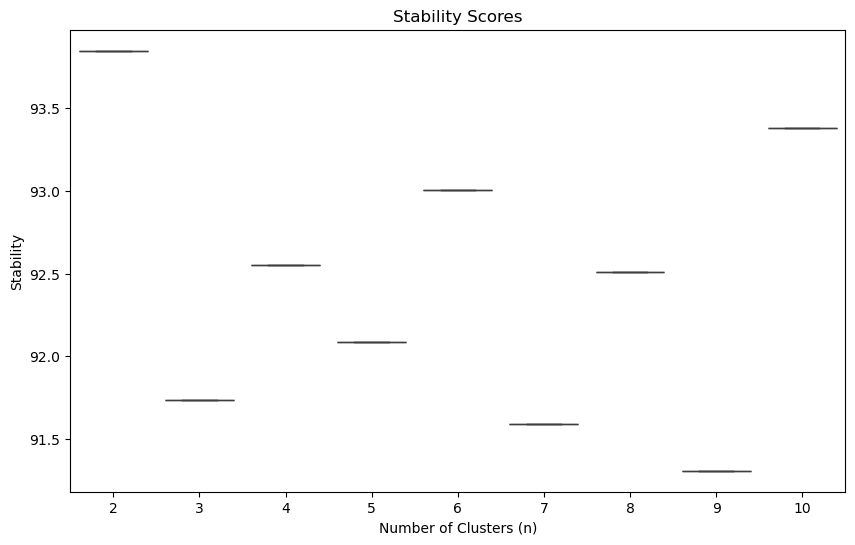

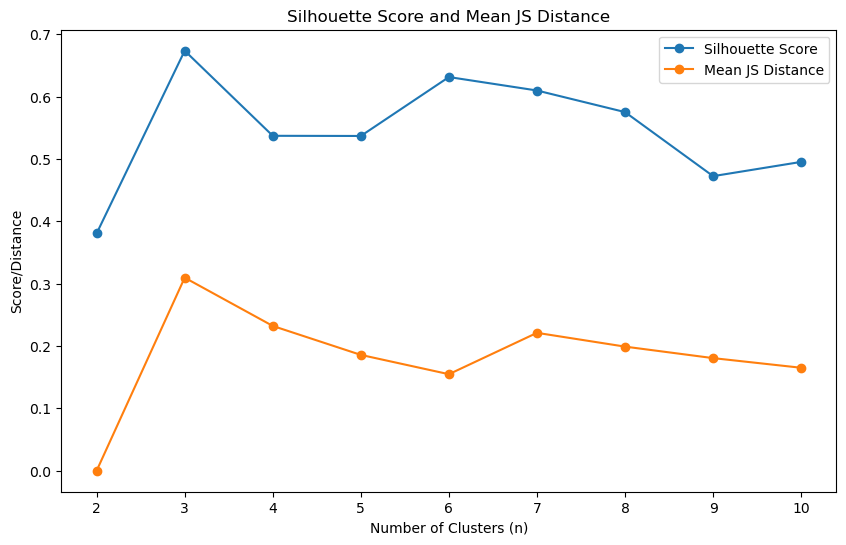

n = 2, Stability Score = 93.85%, Silhouette Score = 0.381, Mean JS Distance = 0.000
n = 3, Stability Score = 91.74%, Silhouette Score = 0.674, Mean JS Distance = 0.310
n = 4, Stability Score = 92.55%, Silhouette Score = 0.537, Mean JS Distance = 0.232
n = 5, Stability Score = 92.09%, Silhouette Score = 0.537, Mean JS Distance = 0.186
n = 6, Stability Score = 93.01%, Silhouette Score = 0.632, Mean JS Distance = 0.155
n = 7, Stability Score = 91.59%, Silhouette Score = 0.610, Mean JS Distance = 0.221
n = 8, Stability Score = 92.51%, Silhouette Score = 0.575, Mean JS Distance = 0.199
n = 9, Stability Score = 91.31%, Silhouette Score = 0.473, Mean JS Distance = 0.181
n = 10, Stability Score = 93.38%, Silhouette Score = 0.495, Mean JS Distance = 0.165


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from PIL import Image

# Ignore warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")

# Assign feature weights
feature_weights = {
    "Solidity": 6,
    "Circularity": 6,
    "Local_Homogeneity": 6,
    "Aspect Ratio": 6
}

# Apply weights to selected features
df_weighted = df.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# Contrastive Clustering Model
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# Optimized UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.05, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Load the original image
original_image_path = "restored_white_background_debug-Copy1.png"
original_image = Image.open(original_image_path).convert("RGB")

# Function to regularize probabilities
def regularize_probabilities(probabilities, epsilon=1e-10):
    return np.clip(probabilities, epsilon, 1.0 - epsilon)

# Initialize result storage
results = []
stability_scores = []
silhouette_scores = []
mean_js_distances = []

# Run KMeans + GMM clustering from n=2 to n=10
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(umap_embeddings)
    
    # Apply GMM initialized with KMeans centroids
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42, means_init=kmeans.cluster_centers_)
    gmm_labels = gmm.fit_predict(umap_embeddings)
    
    # Silhouette Score
    silhouette = silhouette_score(umap_embeddings, gmm_labels)
    silhouette_scores.append(silhouette)
    
    # Jensen-Shannon Distance
    clusters = [umap_embeddings[gmm_labels == i, :] for i in range(n)]
    js_distances = []
    for c1, c2 in combinations(clusters, 2):
        c1_mean = np.mean(c1, axis=0)
        c2_mean = np.mean(c2, axis=0)
        c1_mean = regularize_probabilities(c1_mean)
        c2_mean = regularize_probabilities(c2_mean)
        js_dist = jensenshannon(c1_mean, c2_mean)
        js_distances.append(js_dist)
    
    mean_js_distance = np.nanmean(js_distances) if js_distances else float("nan")
    mean_js_distances.append(mean_js_distance)
    
    # Stability Score
    stability = (1 - np.var(gmm_labels) / (n * n)) * 100
    stability_scores.append(stability)

    # Plot overlay
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image, aspect='auto')
    ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
    ax.set_title(f'Clusters for n = {n}')
    plt.savefig(f"cluster_overlay_n{n}.png")
    plt.close()
    
    # Store results
    results.append((n, stability, silhouette, mean_js_distance))

# Save results to CSV
df['Cluster'] = gmm_labels
df.to_csv('data_with_clusters.csv', index=False)

# Box plot for stability
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.arange(2, 11), y=stability_scores)
plt.title("Stability Scores")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Stability")
plt.savefig("stability_box_plot.png")
plt.show()

# Line graph with Silhouette Score and Mean JS Distance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.plot(np.arange(2, 11), mean_js_distances, label="Mean JS Distance", marker='o')
plt.title("Silhouette Score and Mean JS Distance")
plt.xlabel("Number of Clusters (n)")
plt.ylabel("Score/Distance")
plt.legend()
plt.savefig("silhouette_js_line_graph.png")
plt.show()

# Print final clustering results
for r in results:
    print(f"n = {r[0]}, Stability Score = {r[1]:.2f}%, Silhouette Score = {r[2]:.3f}, Mean JS Distance = {r[3]:.3f}")
